Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/CS-688_Project/IMDB/IMDB Dataset.csv")

In [ ]:
#data=(data.iloc[:100,:])

## Loading Libraries

Doing some experimentations I notice that there was a CUDA error coming with older version of PyTorch, so it's advisable to upgrade PyTorch version.

In [ ]:
!pip install --upgrade torch

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.3 MB/s 
     |████████████████████████████████| 163 kB 89.3 MB/s 
     |████████████████████████████████| 7.6 MB 57.1 MB/s 


In [5]:
import time
import random
import datetime
import numpy as np
import pandas as pd

from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import tensorflow as tf
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [6]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# If there's a GPU available...
if torch.cuda.is_available():    

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")    

There are 1 GPU(s) available.
We will use the GPU: A100-SXM4-40GB


## Processing Data

In [7]:
df=data

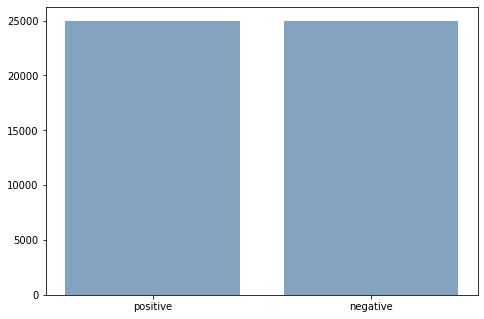

In [8]:
sentence = df['review'].tolist()
label1 = df['sentiment'].tolist()

c = Counter(label1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Intent = []
Occurance = []
for i in c.items():
  Intent.append(i[0])
  Occurance.append(i[1])
ax.bar(Intent,Occurance,color=(0.2, 0.4, 0.6, 0.6))  
plt.show()


## Data Preparation

In [9]:
dic={'positive':0,'negative':1}
ans={0:'positive',1:'negative'}

classes_number = len(dic)

print("classes_number:",classes_number)

classes_number: 2


In [10]:
labels=data['sentiment']
sentence=data['review']

for i in range(len(labels)):
  labels[i]=dic[labels[i]]

In [11]:
for i in range(len(label1)):
 label1[i]=dic[label1[i]]

data={'sentence':sentence,'label1':labels}
df=pd.DataFrame(data)
print(len(df))
df=df.drop_duplicates()
print(len(df))

50000
49582


In [12]:
X_train, X_test, y_train, y_test = train_test_split(sentence, label1, test_size = 0.20, random_state = 0)

In [13]:
sentences = X_train
labels = y_train

In [14]:
label_1_num_classes = classes_number

label1 = torch.LongTensor(labels)

## Loading RoBERTa Model and Creating Data Frame

In [16]:
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Loading RoBERTa tokenizer...
 Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the 

In [17]:
from tqdm import tqdm
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in tqdm(sentences):
    encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 512,pad_to_max_length = True,
                        return_attention_mask = True, return_tensors = 'pt',)
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
all_labels = torch.stack([label1], dim=1)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

  0%|          | 0/40000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 40000/40000 [00:34<00:00, 1149.31it/s]


Original:  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due

In [18]:
dataset = TensorDataset(input_ids, attention_masks, all_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

36,000 training samples
4,000 validation samples


## Training on label 1

In [19]:
batch_size = 32
train_dataloader = DataLoader( train_dataset, shuffle=True, batch_size = batch_size)
validation_dataloader = DataLoader( val_dataset, shuffle=False, batch_size = batch_size )


model = RobertaForSequenceClassification.from_pretrained( 
    "roberta-base", num_labels = classes_number, output_attentions = False, output_hidden_states = False)

model.cuda()

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [20]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [21]:
def flat_accuracy(preds1,labels):
    pred_flat1 = np.argmax(preds1, axis=1).flatten()
    labels = labels.flatten() 
    labels_flat1=np.asarray(labels)
    acc1= np.sum(pred_flat1 == labels_flat1) / len(labels_flat1)
    #return (acc1+acc2)/2
    return acc1

In [22]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # print(b_labels.shape)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       return_dict=True)
        label1_preds = result["logits"][:, :6]
        label1_loss = torch.nn.functional.cross_entropy(label1_preds, b_labels[:, 0])


        loss = label1_loss

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy1 = 0
    total_eval_accuracy2 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           return_dict=True)

        label1_preds = result["logits"][:, :label_1_num_classes]
        label1_loss = torch.nn.functional.cross_entropy(label1_preds, b_labels[:, 0])


        loss = label1_loss 
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        label1_preds = label1_preds.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        eval_1 = flat_accuracy(label1_preds,label_ids)
        total_eval_accuracy1+=eval_1

    # Report the final accuracy for this validation run.
    avg_val_accuracy1 = total_eval_accuracy1 / len(validation_dataloader)
    print("  Accuracy1: {0:.2f}".format(avg_val_accuracy1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur. Label1.': avg_val_accuracy1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
 
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,125.    Elapsed: 0:00:31.
  Batch    80  of  1,125.    Elapsed: 0:00:59.
  Batch   120  of  1,125.    Elapsed: 0:01:27.
  Batch   160  of  1,125.    Elapsed: 0:01:55.
  Batch   200  of  1,125.    Elapsed: 0:02:24.
  Batch   240  of  1,125.    Elapsed: 0:02:52.
  Batch   280  of  1,125.    Elapsed: 0:03:20.
  Batch   320  of  1,125.    Elapsed: 0:03:48.
  Batch   360  of  1,125.    Elapsed: 0:04:16.
  Batch   400  of  1,125.    Elapsed: 0:04:44.
  Batch   440  of  1,125.    Elapsed: 0:05:13.
  Batch   480  of  1,125.    Elapsed: 0:05:41.
  Batch   520  of  1,125.    Elapsed: 0:06:09.
  Batch   560  of  1,125.    Elapsed: 0:06:37.
  Batch   600  of  1,125.    Elapsed: 0:07:05.
  Batch   640  of  1,125.    Elapsed: 0:07:33.
  Batch   680  of  1,125.    Elapsed: 0:08:02.
  Batch   720  of  1,125.    Elapsed: 0:08:30.
  Batch   760  of  1,125.    Elapsed: 0:08:58.
  Batch   800  of  1,125.    Elapsed: 0:09:26.
  Batch   840  of

## Calculating testing accuracy.

In [24]:
data={'sentence':X_test,'label':y_test}
df=pd.DataFrame(data, columns =['label','sentence']) 

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

label_1_num_classes = classes_number

# from sklearn.preprocessing import LabelEncoder

# label1_encoder = LabelEncoder()

# label1 = [item[0] for item in labels]
# label1 = label1_encoder.fit_transform(label1)

label1 = torch.LongTensor(labels)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                sent,add_special_tokens = True,max_length = 512,pad_to_max_length = True, return_attention_mask = True,return_tensors = 'pt',)
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
all_labels = torch.stack([label1], dim=1)

# Set the batch size.  
batch_size = 32  


# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, all_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, shuffle=False, batch_size=batch_size)

Number of test sentences: 10,000



In [27]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
prediction_list = []
real_list=[]
accuracy1 = 0
total_count = 0
misclassify1=0
misclassify_data=[]

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  #logits = result.logits
  label1_preds = result["logits"][:, :label_1_num_classes]

  # Move logits and labels to CPU
  label1_preds = label1_preds.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  label1_preds=np.argmax(label1_preds,axis=1)
  label_ids = label_ids.flatten()

  for i in range(len(label_ids)):
    prediction_list.append(label1_preds[i])
    real_list.append(label_ids[i])
    if(label1_preds[i]==label_ids[i]):
      accuracy1+=1
    else:
      misclassify1+=1

print("")

print("Number of Label1 correctly predicted: "+str(accuracy1))
print("Number of Label1 misclassify: "+str(misclassify1))

print("Label1 Testing Accuracy: {:.2f}".format(accuracy1/(accuracy1+misclassify1) ) )
bert_singlelabel_accuracy1 = accuracy1/(accuracy1+misclassify1)

Predicting labels for 10,000 test sentences...

Number of Label1 correctly predicted: 9568
Number of Label1 misclassify: 432
Label1 Testing Accuracy: 0.96


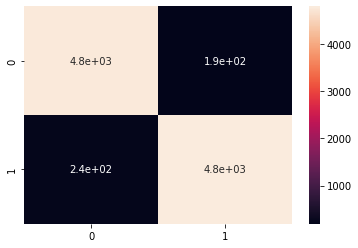

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(real_list,prediction_list), annot=True)